In [1]:
import os
from numpy import *
import pandas as pd

import matplotlib.pyplot as plt
# import seaborn as sns
import geopandas as gpd

from rasterstats import zonal_stats
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob, os
# run for jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import fiona
import json

In [2]:
import rtree
from shapely.geometry import shape, mapping, Point, LinearRing

### Folder Structure

In [3]:
path_gis = '/scratch/users/asimoes/data/india_gis/'
%cd {path_gis}
%ls

/scratch/users/asimoes/data/india_gis
assembly/  parliamentary/


## Read deforestation/census data

In [5]:
path_inp = '/scratch/users/asimoes/data/processed/'
vil = gpd.read_file(path_inp + 'vil_points_2011.gpkg')

KeyboardInterrupt: 

In [ ]:
print('ok')

## Merge SHRID

In [6]:
df_shrid = pd.read_csv('/scratch/users/asimoes/data/intermediate/villages_w_vcf_2011.csv',dtype={'CODE_2011':str,'shrid':str})
vil = vil.merge(df_shrid[['shrid','CODE_2011']].drop_duplicates(),on='CODE_2011',how='left')
vil.shape

/home/users/asimoes/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(615279, 162)

## Read consituency boundaries - AC

In [4]:
#Read data
def isvalid(geom):
    try:
        shape(geom)
        return 1
    except:
        return 0
    
def read_treat_error(path):
    collection = list(fiona.open(path,'r'))
    df1 = pd.DataFrame(collection)
    #Check Geometry
#     pdb.set_trace()
    if 'MADHYA PRADESH' in path:
        df1 = df1.drop(147)
        df1 = df1.drop(148)
    df1['isvalid'] = df1['geometry'].apply(lambda x: isvalid(x))
    df1 = df1[df1['isvalid'] == 1]
    collection = json.loads(df1.to_json(orient='records'))

    #Convert to geodataframe
    gdf = gpd.GeoDataFrame.from_features(collection)
    
    return gdf

In [8]:
path_ac = path_gis + 'assembly/POST DELIMITATION/'

list_files = os.listdir(path_ac)

list_files = [x.split('.')[0] for x in list_files]

list_files = list(set(list_files))

list_gdfs = []

for fil in list_files:
    if 'post_delimitation' not in fil:
        temp = read_treat_error(path_ac+fil+'.shp')
        list_gdfs.append(temp)

In [9]:
ac = pd.concat(list_gdfs,sort=False,ignore_index=True)

In [10]:
ac.head()

,geometry,JK_ID,AC_NO,AC_NAME,STATE_UT,CATEGORY,T_ELECT_08,T_V_PL_08,P_V_PLD_08,N_P__ST_08,...,TRD_PRT_03,TRD_P_V_03,T_VT_PL_08,WN_CND_08,WN_PRTY_08,WN_V_PL_08,SND_P_V_08,TRD_P_V_08,GUJARAT_ID,HP_ID
0,"POLYGON ((77.57808 35.39888, 77.57571 35.39656...",1.0,0.0,DATA NOT AVAILABLE,Jammu & Kasmir,None,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"POLYGON ((76.41376 34.89877, 76.42271 34.89607...",2.0,48.0,Leh,Jammu & Kasmir,None,61663.0,37640.0,61.0,183.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((76.00068 34.60614, 76.00463 34.61198...",3.0,47.0,Nobra,Jammu & Kasmir,None,12093.0,8617.0,71.0,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"POLYGON ((75.25462 34.62896, 75.26775 34.63229...",4.0,49.0,Kargil,Jammu & Kasmir,None,56967.0,42757.0,75.0,158.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((74.57425 34.59931, 74.57450 34.59998...",5.0,9.0,Gurez,Jammu & Kasmir,None,15390.0,11392.0,74.0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#Seems that columns of interest are ['AC_NAME','AC_NO','STATE_UT','ID OF THE STATE']
print (ac.shape)
print (ac.drop_duplicates('geometry').shape)

(4060, 396)
(4060, 396)


## Spatial merge AC

In [12]:
vil['centroid'] = vil.centroid
vil["x"] = vil.centroid.map(lambda p: p.x)
vil["y"] = vil.centroid.map(lambda p: p.y)
vil = vil.set_geometry('centroid')
vil.rename(columns={'geometry':'orig_geometry'},inplace=True)

In [13]:
vil.drop('index_right',axis=1,inplace=True)#Investigate

In [14]:
vil_ac = gpd.sjoin(vil, 
                      ac.loc[:, ['AC_NAME','AC_NO','STATE_UT','geometry']], how='left', op='intersects')

/home/users/asimoes/.local/lib/python3.6/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [16]:
vil_ac['isvalid'] = vil_ac.geometry.apply(lambda x: isvalid(x))
print (vil_ac[vil_ac.isvalid==0].shape)

(0, 168)


In [17]:
vil.shape
vil_ac.shape

(615279, 164)

(615323, 168)

In [18]:
vil_ac.rename(columns={'orig_geometry':'geometry'},inplace=True)
vil_ac = vil_ac.set_geometry('geometry')
vil_ac.drop(['centroid'], inplace = True, axis=1)

In [19]:
vil_ac.to_file("/scratch/users/asimoes/data/processed/defor_shrug_ac_2011.gpkg", driver='GPKG')

In [5]:
path_inp = '/scratch/users/asimoes/data/processed/'
vil_ac = gpd.read_file(path_inp + 'defor_shrug_ac_2011.gpkg')

In [20]:
vil_ac.rename(columns={'index_right':'index_ac','STATE_UT_right':'STATE_UT_ac'},inplace=True)

In [7]:
#What to do with these??
print (vil_ac[vil_ac.AC_NO.isnull()].shape)
print (vil_ac[vil_ac.shrid.isnull()].shape)# - MAIN PROBLEM
print (vil_ac[(vil_ac.AC_NO.isnull())&(vil_ac.shrid.isnull())].shape)

(993, 165)
(22856, 165)
(64, 165)


## Read constituency boundaries - PC

In [21]:
path_pc = path_gis + 'parliamentary/POST DELIMITATION/'

pc = read_treat_error(path_pc+'LOKSABHA_15.shp')

In [22]:
pc.shape
pc.drop_duplicates('CONST_NAME').shape

(545, 25)

(541, 25)

In [10]:
pc.columns

Index(['geometry', 'LOK15C_ID', 'CONST_NAME', 'PC_NO', 'STATE_UT', 'M_ELCT_15',
       'F_ELCT_15', 'TOT_ELC_15', 'M_VOT_15', 'F_VOT_15', 'TOT_VOT_15',
       'P_V_PLD_15', 'VLD_VT_15', 'N_P_ST_15', 'AV_E_PS_15', 'POL_DT_15',
       'COU_DT_15', 'DEC_DT_15', 'WN_CND_15', 'WN_PRT_15', 'W_PT_VT_15',
       'SND_CND_15', 'SND_PRT_15', 'S_PT_VT_15', 'MRG_1_2_15'],
      dtype='object')

## Merge PC

In [23]:
vil_ac['centroid'] = vil_ac.centroid
vil_ac["x"] = vil_ac.centroid.map(lambda p: p.x)
vil_ac["y"] = vil_ac.centroid.map(lambda p: p.y)
vil_ac = vil_ac.set_geometry('centroid')
vil_ac.rename(columns={'geometry':'orig_geometry'},inplace=True)

In [24]:
%%time
vil_ac_pc = gpd.sjoin(vil_ac, 
                      pc.loc[:, ['geometry', 'LOK15C_ID', 'CONST_NAME', 'PC_NO','STATE_UT']], how='left', op='intersects')

/home/users/asimoes/.local/lib/python3.6/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


CPU times: user 1min 58s, sys: 3.57 s, total: 2min 2s
Wall time: 2min 2s


In [25]:
vil_ac_pc['isvalid'] = vil_ac_pc.geometry.apply(lambda x: isvalid(x))
print (vil_ac_pc[vil_ac_pc.isvalid==0].shape)

(0, 173)


In [26]:
vil_ac.shape
vil_ac_pc.shape

(615323, 168)

(615323, 173)

In [27]:
vil_ac_pc.rename(columns={'orig_geometry':'geometry'},inplace=True)
vil_ac_pc = vil_ac_pc.set_geometry('geometry')
vil_ac_pc.drop(['centroid'], inplace = True, axis=1)

In [28]:
vil_ac_pc.to_file("/scratch/users/asimoes/data/processed/defor_shrug_ac_pc_2011.gpkg", driver='GPKG')

## Read AC/PC and Merge Pollution

In [5]:
vil_ac_pc = gpd.read_file("/scratch/users/asimoes/data/processed/defor_shrug_ac_pc_2011.gpkg")

In [29]:
vil_ac_pc.crs

{'init': 'epsg:4326'}

In [30]:
path_poll = '/scratch/users/asimoes/data/pollution/input/PM_25_Rasters/'

In [31]:
years = range(1998,2017)

In [32]:
vil_ac_pc.shape

(615323, 172)

In [ ]:
for year in years:
    vil_ac_pc_pol = vil_ac_pc.copy()
    def_master = path_poll + 'gwr_pm25_' + str(year) + '.tif'
    vil_ac_pc = gpd.GeoDataFrame.from_features( zonal_stats(vil_ac_pc, def_master,   
            prefix = str(year)[-2:]+'_pollution_', stats="min mean max median majority count percentile_25 percentile_75", nodata=-1, #q25 q75
            geojson_out=True))
    vil_ac_pc.crs = vil_ac_pc_pol.crs

/home/users/asimoes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/users/asimoes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [ ]:
vil_ac_pc_pol = vil_ac_pc.copy()

In [ ]:
vil_ac_pc_pol.shape

In [ ]:
path_out = '/scratch/users/asimoes/data/processed/'
vil_ac_pc_pol.to_file(path_out + 'defor_shrug_ac_pc_pol_2011.gpkg', driver='GPKG')

## Read Final File

In [ ]:
%%time
path_out = '/scratch/users/asimoes/data/processed/'
vil_ac_pc_pol = gpd.read_file(path_out + 'defor_shrug_ac_pc_pol_2011.gpkg')

In [ ]:
vil_ac_pc_pol.shape

In [31]:
vil_ac_pc_pol.STATE.unique()

array([None], dtype=object)

In [35]:
#Original
vil_ac_pc_pol.STATE_UT_left.unique()
#PC
vil_ac_pc_pol.STATE_UT.unique()
#AC
vil_ac_pc_pol.STATE_UT_ac.unique()

array(['Uttarakhand', 'Rajasthan', 'Madhya Pradesh', 'Tamil Nadu',
       'Karnataka', 'Kerala', 'Gujarat', 'Himachal Pradesh',
       'Chhattisgarh', 'Maharashtra', 'Uttar Pradesh', 'West Bengal',
       'Andhra Pradesh', 'Tripura', 'Jammu & Kashmir', 'Delhi', 'Haryana',
       'Sikkim', 'Jharkhand', 'Punjab', 'Assam', 'Chandigarh', 'Odisha',
       'Bihar', 'Goa', 'Manipur', 'Puducherry', 'Dadra & Nagar Haveli',
       'Daman & Diu'], dtype=object)

In [27]:
#Min is causing a problem on the scale of the graph
min_pol = vil_ac_pc_pol[~vil_ac_pc_pol['16_pollution_min'].isnull()]['16_pollution_min'].min()

In [28]:
vil_ac_pc_pol[vil_ac_pc_pol['16_pollution_min']!=min_pol]['16_pollution_min'].min()

4.099999904632568

/home/users/asimoes/.local/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


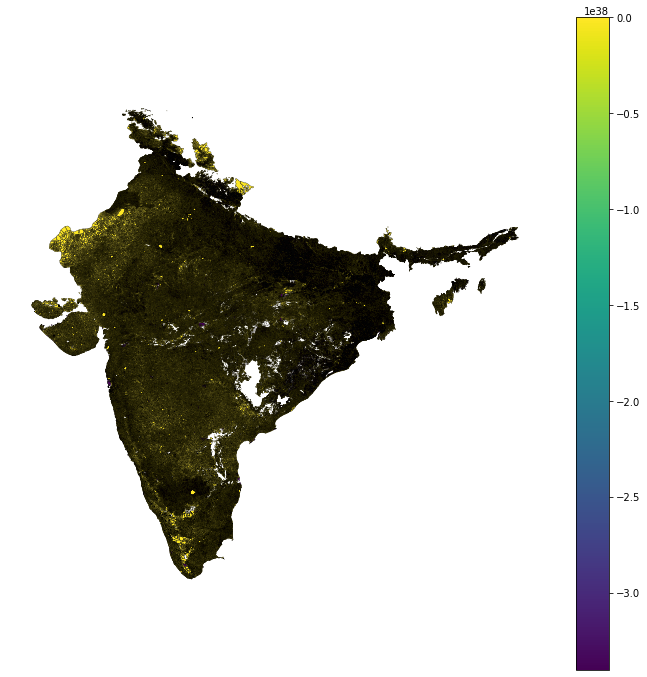

In [7]:
f, ax = plt.subplots(1, figsize=(12,12))
vil_ac_pc_pol.plot(column='16_pollution_min', legend=True, edgecolor='k',linewidth=0.3,ax=ax)
ax.set_axis_off()

/home/users/asimoes/.local/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


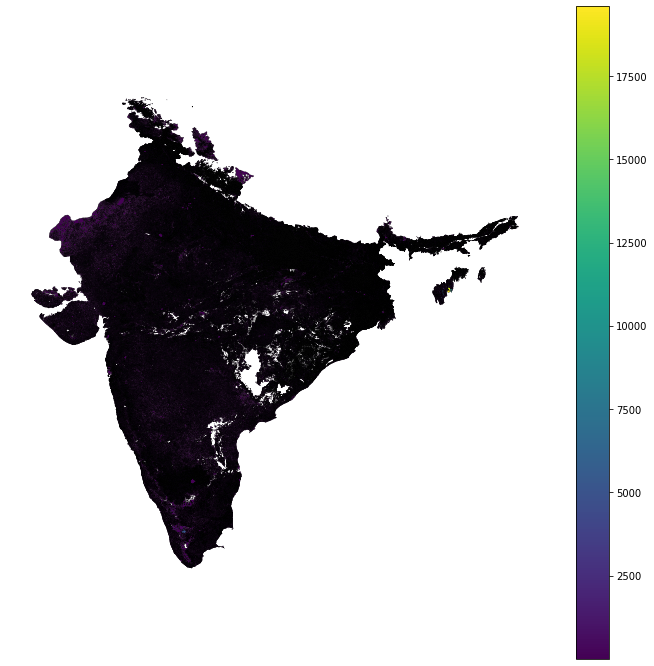

In [9]:
f, ax = plt.subplots(1, figsize=(12,12))
vil_ac_pc_pol.plot(column='deforest_17', legend=True, edgecolor='k',linewidth=0.3,ax=ax)
ax.set_axis_off()

/home/users/asimoes/.local/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


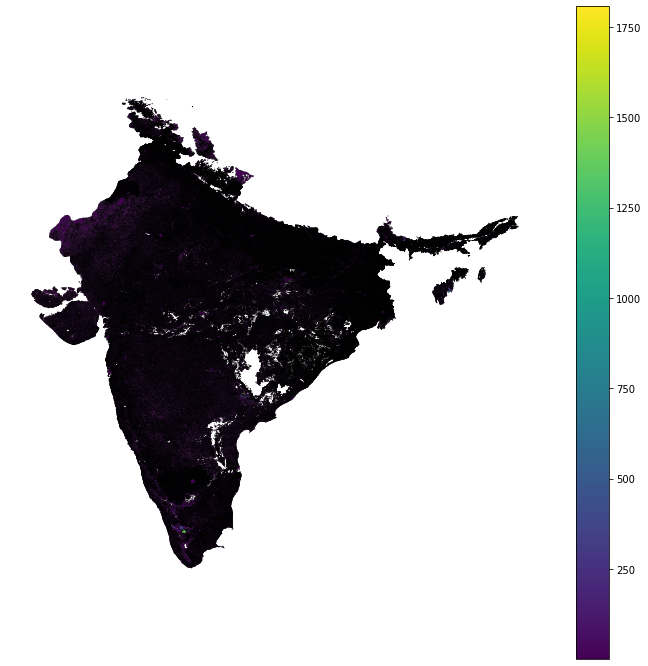

In [10]:
f, ax = plt.subplots(1, figsize=(12,12))
vil_ac_pc_pol.plot(column='deforest_2', legend=True, edgecolor='k',linewidth=0.3,ax=ax)
ax.set_axis_off()

## Testing merge with urban SHRID

In [ ]:
#Merge the urban shrids
df_shrid = pd.read_csv('/scratch/users/asimoes/data/intermediate/villages_w_vcf_2011.csv',dtype={'CODE_2011':str,'shrid':str})

In [8]:
df_shrid_u = pd.read_csv('/home/users/asimoes/data/admin/shrug_1/shrug-v1.1.samosa-keys-csv/shrug_pc11u_key.csv')

In [9]:
df_shrid_u.head()

,pc11_state_id,pc11_town_id,shrid
0,1,123,11-01-000123
1,1,124,11-01-000124
2,1,125,11-01-000125
3,1,126,11-01-000126
4,1,127,11-01-000127


In [19]:
vil_ac_pc_pol.CODE_2011.str.len().value_counts()

16    615115
20       132
18        39
17        37
Name: CODE_2011, dtype: int64

In [20]:
#None of these seem to be able to be represented from pc11_state_id	pc11_town_id 
#and all the others have more than 4 non-zero digits
vil_ac_pc_pol[vil_ac_pc_pol.CODE_2011.str.count('0')>=12].CODE_2011

193269    0100200007000700
201532    0100100001000020
201536    0100100001000010
201537    0100100001000009
201546    0100100001000050
201566    0100100001000030
201568    0100100001000040
433916    0100100001000060
433935    0100100001000100
447171    0100200006000600
448426    0100100001000004
448427    0100100001000002
448428    0100100001000001
448430    0100100001000005
448431    0100100001000006
448433    0100100001000003
448441    0100100001000090
448443    0100100001000080
529544    0100200005000500
530957    0100100001000007
530959    0100100001000008
530964    0100100001000070
550696    0100100002000200
550742    0100100002000300
594969    0100200004000400
599630    0100200008000800
Name: CODE_2011, dtype: object